# A Sentiment Analysis of MLB Performance

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [2]:
#Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np
import seaborn as sns

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

##### The first step is to scrape the text from the blog posts from the mlbtraderumors.com website. The posts include text, dates posted, and the authors name, all of which will be scraped before storing into a dataframe to use and start the text analysis.

# Acquire Text Data

In [3]:
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    # Drop rows without content
    df.dropna()

    return df

# Chicago White Sox Data Collection and Cleaning

In [4]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/chicago-white-sox?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_chicago_white_sox_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,"June 21, 2023",Twins outfielder Byron Buxton has dealt with m...
1,MLBTR Trade Rumors Podcast: Exciting Youth Mov...,Darragh McDonald,"June 21, 2023",The latest episode of the MLB Trade Rumors Pod...
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,"June 20, 2023",The White Sox have claimed right-hander Touki ...
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,"June 19, 2023",The White Sox announced a handful of transacti...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,"June 16, 2023",The White Sox placed starter Mike Clevinger on...


In [5]:
# Change the Data column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [6]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [7]:
# Check for missing values
df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [8]:
len(df)

1030

In [9]:
df = df.dropna()
df

,Title,Author,Date,Content
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,Twins outfielder Byron Buxton has dealt with m...
1,MLBTR Trade Rumors Podcast: Exciting Youth Mov...,Darragh McDonald,2023-06-21,The latest episode of the MLB Trade Rumors Pod...
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,The White Sox have claimed right-hander Touki ...
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transacti...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,The White Sox placed starter Mike Clevinger on...
...,...,...,...,...
995,White Sox Outright Dustin Garneau,Connor Byrne,2018-10-02,The White Sox have outrighted catcher Dustin G...
996,Rick Hahn On White Sox’ Offseason Plans,Jeff Todd,2018-09-27,White Sox GM Rick Hahn addressed the media yes...
997,Avisail Garcia To Undergo Knee Surgery,Jeff Todd,2018-09-25,White Sox outfielder Avisail Garcia is set to ...
998,"Past, Present & Future: American League Closer...",Jason Martinez,2018-09-25,"By the end of the 2017 season, the list of pit..."


In [10]:
len(df)

1000

## Import data on the Chicago White Sox from baseball-reference.com.

https://www.baseball-reference.com/teams/CHW/attend.shtml

In [11]:
# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/CHW/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/white_sox_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/white_sox_statistics.csv


In [12]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

white_sox_df = pd.DataFrame(pd.read_csv(path + 'white_sox_statistics.csv'))
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field


In [13]:
white_sox_df= white_sox_df[white_sox_df['Year'] > 2004]
white_sox_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field
5,2018,Chicago White Sox,AL Central,62,100,4,NaN,1608817.0,19862.0,12th of 15,"$75,092,000",99,98,Guaranteed Rate Field
6,2017,Chicago White Sox,AL Central,67,95,4,NaN,1629470.0,20117.0,13th of 15,"$97,842,000",98,97,Guaranteed Rate Field
7,2016,Chicago White Sox,AL Central,78,84,4,NaN,1746293.0,21559.0,12th of 15,"$113,416,000",96,96,U.S. Cellular Field
8,2015,Chicago White Sox,AL Central,76,86,4,NaN,1755810.0,21677.0,13th of 15,"$112,889,700",97,96,U.S. Cellular Field
9,2014,Chicago White Sox,AL Central,73,89,4,NaN,1650821.0,20381.0,13th of 15,"$87,475,500",98,97,U.S. Cellular Field


In [14]:
# Remove the dollar and comma signs from the following columns:
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].replace({'\$':''}, regex = True)
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].replace({'\,':''}, regex = True)
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,157571666,104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334,103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333,101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333,100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333,99,98,Guaranteed Rate Field


In [15]:
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].astype(float)
white_sox_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

## Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [16]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
white_sox_df['success'] = (white_sox_df['W'] / (white_sox_df['W'] + white_sox_df['L']) >= 0.5).astype(int)
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,157571666.0,104,104,Guaranteed Rate Field,0
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334.0,103,103,Guaranteed Rate Field,1
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333.0,101,102,Guaranteed Rate Field,1
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333.0,100,100,Guaranteed Rate Field,1
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333.0,99,98,Guaranteed Rate Field,0


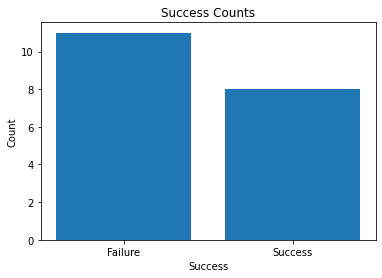

In [17]:
# Count the number of successes and failures
success_counts = white_sox_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

In [18]:
white_sox_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.00000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,74.368421,77.684211,3.00000,1.945840e+06,24598.166667,1.087984e+08,101.789474,101.473684,0.421053
std,5.627314,17.493524,18.508414,1.20185,5.110815e+05,5122.477425,2.436409e+07,3.137213,3.372576,0.507257
min,2005.000000,32.000000,25.000000,1.00000,6.790770e+05,18863.000000,7.509200e+07,96.000000,96.000000,0.000000
25%,2009.500000,69.500000,73.000000,2.00000,1.650036e+06,20441.250000,9.265875e+07,99.000000,98.000000,0.000000
50%,2014.000000,78.000000,83.000000,3.00000,1.867184e+06,23051.500000,1.086718e+08,103.000000,103.000000,0.000000
75%,2018.500000,86.500000,89.000000,4.00000,2.261717e+06,27922.750000,1.186372e+08,104.000000,104.000000,1.000000
max,2023.000000,99.000000,100.000000,5.00000,2.957414e+06,36511.000000,1.639583e+08,106.000000,106.000000,1.000000


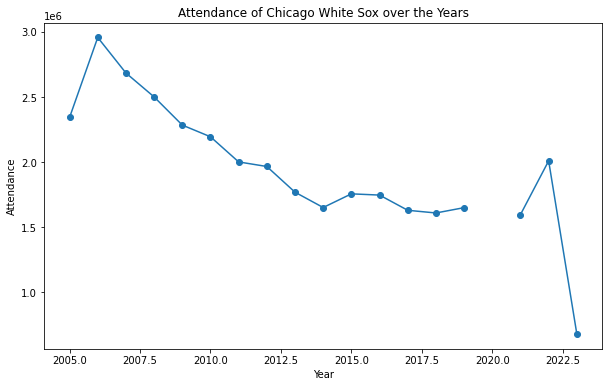

In [19]:
# Plotting the data
# Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
attendance = np.array(white_sox_df['Attendance'])

plt.figure(figsize=(10, 6))

# Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Chicago White Sox over the Years')

# Display the plot
plt.show()

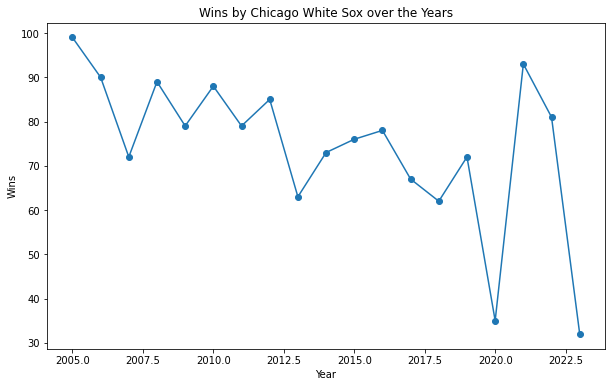

In [20]:
# Plotting Wins over the years
year = np.array(white_sox_df['Year'])
wins = np.array(white_sox_df['W'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Chicago White Sox over the Years')

# Display the plot
plt.show()

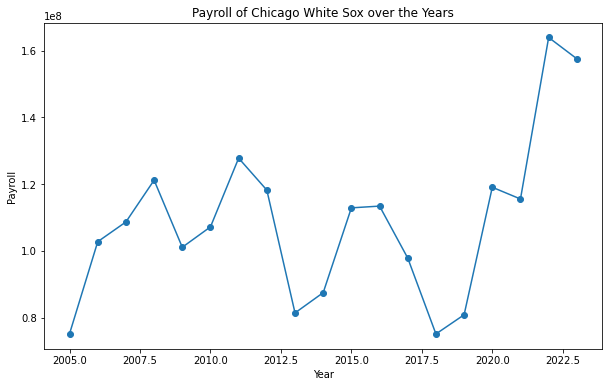

In [21]:
# Plotting Payroll over the years
# Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
payroll = np.array(white_sox_df['Est. Payroll'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Chicago White Sox over the Years')

# Display the plot
plt.show()

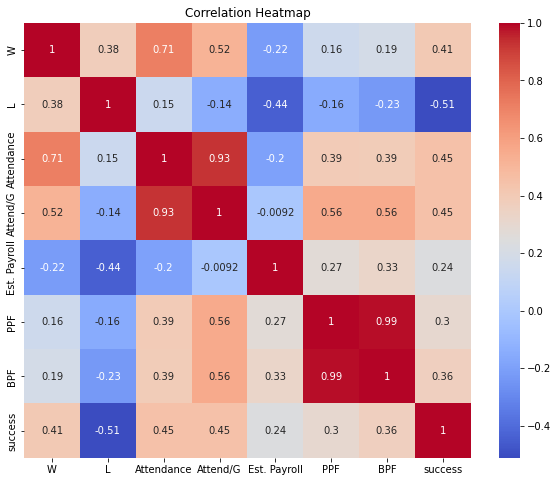

In [22]:
# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = white_sox_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

#### Add column to analyze whether blog post occurred in a successful year or not.

In [23]:
# Extract the year from the "Date" column in df DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge df and nats_df DataFrames on the "Year" column
merged_df = pd.merge(df, white_sox_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_df['Year_Successful'] = merged_df['success'].fillna(0).astype(int)

merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,Twins outfielder Byron Buxton has dealt with m...,2023,0,0
1,MLBTR Trade Rumors Podcast: Exciting Youth Mov...,Darragh McDonald,2023-06-21,The latest episode of the MLB Trade Rumors Pod...,2023,0,0
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,The White Sox have claimed right-hander Touki ...,2023,0,0
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transacti...,2023,0,0
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,The White Sox placed starter Mike Clevinger on...,2023,0,0


In [24]:
len(merged_df)

1000

# Cleaning the Data

In [25]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [26]:
merged_df['Content'].apply

<bound method Series.apply of 0      Twins outfielder Byron Buxton has dealt with m...
1      The latest episode of the MLB Trade Rumors Pod...
2      The White Sox have claimed right-hander Touki ...
3      The White Sox announced a handful of transacti...
4      The White Sox placed starter Mike Clevinger on...
                             ...                        
995    The White Sox have outrighted catcher Dustin G...
996    White Sox GM Rick Hahn addressed the media yes...
997    White Sox outfielder Avisail Garcia is set to ...
998    By the end of the 2017 season, the list of pit...
999    It’s often difficult to feel positive about a ...
Name: Content, Length: 1000, dtype: object>

In [27]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_df['impurity'] = merged_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
333,"The White Sox aren’t planning to make any coaching changes, manager Tony La Russa told Daryl Van...",0.003578
875,Eloy Jimenez’s career-opening extension with the White Sox included “an understanding” that Jime...,0.002797
450,"Adam Engel will begin the season the injured list, as White Sox manager Tony La Russa told repor...",0.002782


##### The steps above displays the highest impurity levels for the White Sox's data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

# Character Normalization and Tokenization

In [28]:
# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

# Apply normalization to the "Contents" column
merged_df["Contents_Normalized"] = merged_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_df[["Content", "Contents_Normalized"]].head()
 	

,Content,Contents_Normalized
0,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...","[twin, outfield, byron, buxton, dealt, mani, injuri, throughout, career, led, twin, use, exclus,..."
1,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...","[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,..."
2,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...","[white, sox, claim, righthand, touki, toussaint, waiver, guardian, per, announc, club, design, a..."
3,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,"[white, sox, announc, hand, transact, tonight, seri, open, ranger, notabl, recal, infield, prosp..."
4,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...","[white, sox, place, starter, mike, cleving, day, injur, list, retroact, june, due, bicep, inflam..."


In [29]:
merged_df['length'] = merged_df['Contents_Normalized'].str.len()
merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...",2023,0,0,0.0,"[twin, outfield, byron, buxton, dealt, mani, injuri, throughout, career, led, twin, use, exclus,...",377
1,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,0,0,0.0,"[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,...",124
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...",2023,0,0,0.0,"[white, sox, claim, righthand, touki, toussaint, waiver, guardian, per, announc, club, design, a...",143
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,2023,0,0,0.0,"[white, sox, announc, hand, transact, tonight, seri, open, ranger, notabl, recal, infield, prosp...",165
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...",2023,0,0,0.0,"[white, sox, place, starter, mike, cleving, day, injur, list, retroact, june, due, bicep, inflam...",229


# Analyze descriptive statistics for text in dataframe.

<Axes: >

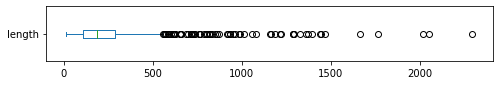

In [30]:
merged_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

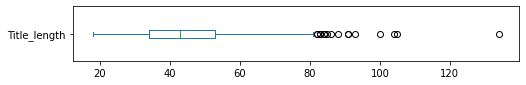

In [31]:
merged_df['Title_length'] = merged_df['Title'].str.len()
merged_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

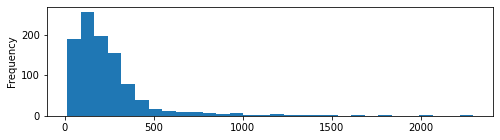

In [32]:
merged_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

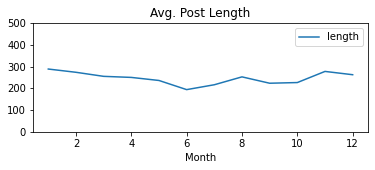

In [33]:
# Extract the month from the date and create a new column
merged_df['Month'] = merged_df['Date'].dt.month

# Plot the average post length
merged_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))


In [34]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [35]:
freq_df = count_words(merged_df)
freq_df.head(5)

,freq
token,
sox,3881
season,3077
white,2872
year,2174
mm,1970


In [36]:
#How many tokens are in the df?
len(freq_df)

6278

In [37]:
# top words with 10+ characters
count_words(merged_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)

,freq
token,
appearances,647
outfielder,376
organization,335
arbitration,243
assignment,236


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

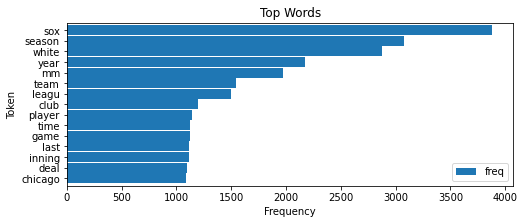

In [38]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')